# Что тут происходит
> пытаемся запустить многоклассовую сегментацию
> есть выделение масок разных классов
> и дальнейшее объединение в один тензор
> куча всего теперь там индексный тензор, который тоже ему не подходит...
# Продолжаем мучить нашу сегментацию.
В этот раз сделаем собственную модель Unet для обучения.



# Импорт библиотек

In [24]:
!pip install albumentations --user

  Using cached albumentations-1.4.0-py3-none-any.whl (123 kB)
  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Using cached scikit_image-0.22.0-cp39-cp39-win_amd64.whl (24.5 MB)
  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-win_amd64.whl (38.5 MB)
  Using cached imageio-2.34.0-py3-none-any.whl (313 kB)
  Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


In [23]:
# Import necessary libraries
import numpy as np
import pandas as pd
import random
import json
import matplotlib.pyplot as plt

import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import gc
import os
import re
import shutil

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage

from PIL import Image

ModuleNotFoundError: No module named 'albumentations'

# Установка параметров нашей модели

In [2]:
# Создадим пути к папке с изображениями
TRAIN_DATA_PATH = 'D:/SNO/WINEYARD/DIFF_VAR/tynshun_wineyard_coco_panoptic/export_coco-panoptic_tynshun_wineyard_v.0.1.json'

ANNOTATION_DATA_PATH = 'D:/SNO/WINEYARD/DIFF_VAR/tynshun_wineyard_coco_panoptic/export_coco-panoptic_tynshun_wineyard_v.0.1.json'
DATA_DIR = 'D:/SNO/WINEYARD/DIFF_VAR/tynshun_wineyard_coco_panoptic/v.0.1/'

# Создадим пути к папкам train, val, test
TRAIN_DIR = 'D:/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TRAIN/'
VAL_DIR = 'D:/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/VAL/'
TEST_DIR = 'D:/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/'

# Выберем устройство для вычислений
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Выставим гиперпараметры
EPOCHS = 10        # number of epochs
LR = 0.001         # Learning rate
IMG_SIZE = 32     # Size of image 320
BATCH_SIZE = 32    # Batch size


# 1. Разобьем нашу папку на train, val, test. Нужно всего один раз!

## 1.1. Удалим все не нужные файлы

In [58]:
folder_path = DATA_DIR

# Получаем список файлов в папке
file_list = os.listdir(folder_path)
# Задаем шаблон для поиска файлов второго типа
pattern = re.compile(r'frame_\d+_label_ground-truth\.png')
# Проходим по каждому файлу и удаляем файлы второго типа
for file_name in file_list:
    if pattern.match(file_name):
        os.remove(os.path.join(folder_path, file_name))
        print(f'Файл {file_name} удален.')

print("Удаление завершено.")


Файл frame_10853_label_ground-truth.png удален.
Файл frame_10854_label_ground-truth.png удален.
Файл frame_10889_label_ground-truth.png удален.
Файл frame_10926_label_ground-truth.png удален.
Файл frame_10928_label_ground-truth.png удален.
Файл frame_10989_label_ground-truth.png удален.
Файл frame_11013_label_ground-truth.png удален.
Файл frame_11026_label_ground-truth.png удален.
Файл frame_11566_label_ground-truth.png удален.
Файл frame_11569_label_ground-truth.png удален.
Файл frame_11578_label_ground-truth.png удален.
Файл frame_11594_label_ground-truth.png удален.
Файл frame_11611_label_ground-truth.png удален.
Файл frame_11647_label_ground-truth.png удален.
Файл frame_11651_label_ground-truth.png удален.
Файл frame_11652_label_ground-truth.png удален.
Файл frame_11665_label_ground-truth.png удален.
Файл frame_11702_label_ground-truth.png удален.
Файл frame_11738_label_ground-truth.png удален.
Файл frame_11749_label_ground-truth.png удален.
Файл frame_11754_label_ground-truth.png 

## 1.2. Создадим два списка файлов - маски и изображения

In [4]:
file_list = os.listdir(DATA_DIR)
image_list = []
mask_list = []
pattern_image = re.compile(r'frame_\d+\.jpg')
pattern_mask = re.compile(r'frame_\d+_label_ground-truth_coco-panoptic\.png')
for file_name in file_list:
    if pattern_image.match(file_name):
        image_list.append(file_name)
    if pattern_mask.match(file_name):
        mask_list.append(file_name)
    
image_list, mask_list

(['frame_10853.jpg',
  'frame_10854.jpg',
  'frame_10889.jpg',
  'frame_10926.jpg',
  'frame_10928.jpg',
  'frame_10989.jpg',
  'frame_11013.jpg',
  'frame_11026.jpg',
  'frame_11566.jpg',
  'frame_11569.jpg',
  'frame_11578.jpg',
  'frame_11594.jpg',
  'frame_11611.jpg',
  'frame_11647.jpg',
  'frame_11651.jpg',
  'frame_11652.jpg',
  'frame_11665.jpg',
  'frame_11702.jpg',
  'frame_11738.jpg',
  'frame_11749.jpg',
  'frame_11754.jpg',
  'frame_11788.jpg',
  'frame_11819.jpg',
  'frame_11893.jpg',
  'frame_11912.jpg',
  'frame_11920.jpg',
  'frame_11927.jpg',
  'frame_11928.jpg',
  'frame_12019.jpg',
  'frame_12021.jpg',
  'frame_12042.jpg',
  'frame_12046.jpg',
  'frame_12064.jpg',
  'frame_12067.jpg',
  'frame_12075.jpg',
  'frame_12077.jpg',
  'frame_12124.jpg',
  'frame_12137.jpg',
  'frame_12154.jpg',
  'frame_12195.jpg',
  'frame_12207.jpg',
  'frame_12222.jpg',
  'frame_12229.jpg',
  'frame_12250.jpg',
  'frame_12259.jpg',
  'frame_12272.jpg',
  'frame_12281.jpg',
  'frame_1229

## 1.3. Разделяем файлы на train, val и test

In [5]:
train_list, test_val_list = train_test_split(image_list, test_size=0.3, random_state=42)
val_list, test_list = train_test_split(test_val_list, test_size=0.33, random_state=42)
len(train_list), len(val_list), len(test_list)

(210, 60, 30)

In [8]:
# Проходимся по каждому файлу изображения
for image_file in train_list:
    # Проверяем, существует ли соответствующая маска
    image_name, image_extension = os.path.splitext(image_file)
    mask_file = f"{image_name}_label_ground-truth_coco-panoptic.png"
    mask_path = os.path.join(DATA_DIR, mask_file)
    
    # Если маска существует, копируем изображение и маску в папку назначения
    if os.path.exists(mask_path):
        # Копируем изображение
        shutil.copy(os.path.join(DATA_DIR, image_file), os.path.join(TRAIN_DIR, image_file))
        # Копируем маску
        shutil.copy(mask_path, os.path.join(TRAIN_DIR, mask_file))


In [9]:
# Проходимся по каждому файлу изображения
for image_file in val_list:
    # Проверяем, существует ли соответствующая маска
    image_name, image_extension = os.path.splitext(image_file)
    mask_file = f"{image_name}_label_ground-truth_coco-panoptic.png"
    mask_path = os.path.join(DATA_DIR, mask_file)
    
    # Если маска существует, копируем изображение и маску в папку назначения
    if os.path.exists(mask_path):
        # Копируем изображение
        shutil.copy(os.path.join(DATA_DIR, image_file), os.path.join(VAL_DIR, image_file))
        # Копируем маску
        shutil.copy(mask_path, os.path.join(VAL_DIR, mask_file))


In [10]:
# Проходимся по каждому файлу изображения
for image_file in test_list:
    # Проверяем, существует ли соответствующая маска
    image_name, image_extension = os.path.splitext(image_file)
    mask_file = f"{image_name}_label_ground-truth_coco-panoptic.png"
    mask_path = os.path.join(DATA_DIR, mask_file)
    
    # Если маска существует, копируем изображение и маску в папку назначения
    if os.path.exists(mask_path):
        # Копируем изображение
        shutil.copy(os.path.join(DATA_DIR, image_file), os.path.join(TEST_DIR, image_file))
        # Копируем маску
        shutil.copy(mask_path, os.path.join(TEST_DIR, mask_file))

# 2. Вспомогательные функции

## 2.1. Загрузка JSON-файла аннотаций COCO

In [11]:
def get_df_images_masks(path_to_coco, path_to_dir):
    with open(path_to_coco, 'r') as f:
        coco_data = json.load(f)
        df_images = pd.DataFrame(coco_data['images'])
        df_images['file_name'] = df_images['file_name'].apply(lambda x: path_to_dir + x)
        df_images.rename(columns={'id': 'image_id'}, inplace=True)
        df_annotations = pd.DataFrame(coco_data['annotations'])
        df_annotations['file_name'] = df_annotations['file_name'].apply(lambda x: path_to_dir + x)
        # Склеивание DataFrame по столбцу 'id'
        merged_df = pd.merge(df_images, df_annotations, on='image_id')
        merged_df.rename(columns={'file_name_x': 'images'}, inplace=True)
        merged_df.rename(columns={'file_name_y': 'masks'}, inplace=True)
        return merged_df

## 2.2. Функция по поиску классов сегментации и словаря цветов сегментации
## **Гипотетически надо будет поменять на tuple**

In [12]:
def find_classes(directory: str): # указать возвращаемый тип данных
    # дописать многострочный комментарий
    '''
    Функция используется в самодельном классе Dataset
    '''
    with open(directory, 'r') as f:
        data_json = json.load(f)

    type(data_json['categories'])


    classes = ['__background__']
    colors = [[0, 0, 0]]

    colors_idx = dict()
    colors_idx['__background__'] = [0, 0, 0]

    classes_idx = dict()
    classes_idx['__background__'] = 0

    for el in data_json['categories']:
        classes.append(el['name'])
        colors.append(el['color'])
    classes_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    for i in range(len(classes)):
        colors_idx[classes[i]] = colors[i]

    return classes, classes_idx, colors_idx

## 2.3. Функция для вывода 5 случайных изображений

In [13]:
def generate_sample_images(sample):
    imgs = sample.images

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample.masks

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        mask = cv2.imread(mask, cv2.COLOR_BGR2RGB) / 255.0 #перевод в серую шкалу и нормализация! ВАУ!

        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask, cmap='gray')

## 2.4. Функция для отображения

In [46]:
def show_image_from_df(image_path):
    image = cv2.imread(image_path)
  # Отображение изображения
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## 2.5 Получим список файлов в папке

In [51]:
def get_files_list(folder_path):
    return os.listdir(folder_path)

## 2.6 Получим список изображений и масок в папке

In [55]:
def get_image_and_mask_lists(file_list):
    # Получение пути изображения и маски
    image_list = []
    mask_list = []
    pattern_image = re.compile(r'frame_\d+\.jpg')
    pattern_mask = re.compile(r'frame_\d+_label_ground-truth_coco-panoptic\.png')
    for file_name in file_list:
        if pattern_image.match(file_name):
            image_list.append(file_name)
        if pattern_mask.match(file_name):
            mask_list.append(file_name) 
            
    return image_list, mask_list

In [125]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    if seed:
        random.seed(seed)

    random_array = np.random.randint(0, len(dataset), n)
    print(random_array)
    plt.figure(figsize=(16, 8))
    for i, idx in enumerate(random_array):
        image, mask = dataset[idx]
        plt.subplot(2, 5, i+1)
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.axis('off')
        plt.title("IMAGE")

        plt.subplot(2, 5, i+6)
        plt.imshow(np.transpose(mask, (1, 2, 0)), cmap='gray')
        plt.axis('off')
        plt.title("GROUND TRUTH")
    plt.tight_layout()
    plt.show()


# 3. Исследуем наши данные

In [16]:
df = get_df_images_masks(TRAIN_DATA_PATH, DATA_DIR)
df.head()
print(df.shape)

(300, 6)


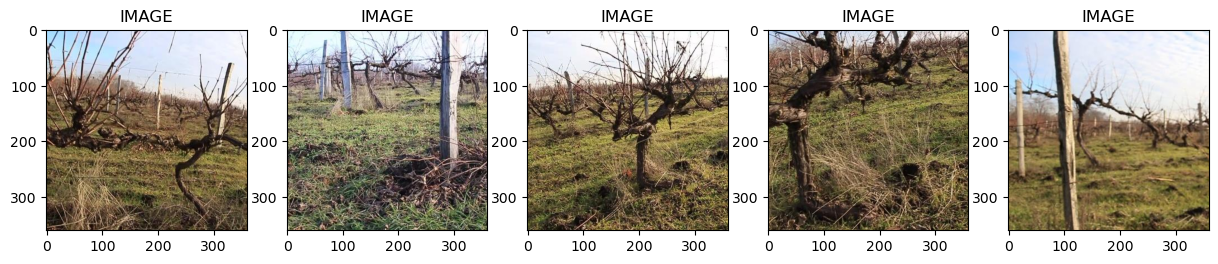

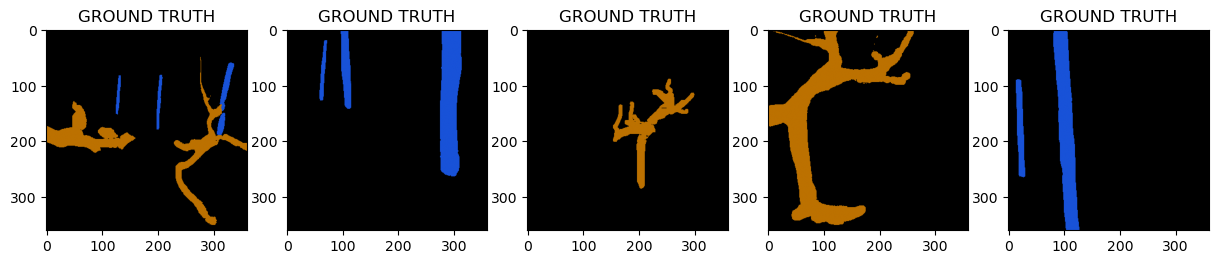

In [17]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]# выберем 5 случайных индексов из нашего df
generate_sample_images(sample)
generate_sample_masks(sample)

# 4. Data Augmentation

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [ ]:
# Creating a data augmentation compose for transforming the data
aug_transform = A.Compose([
    A.RandomSizedCrop(min_max_height=(3500, 4000), height=4000, width=6000, w2h_ratio=1.5, p=0.8),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=(45, 225), interpolation=cv2.INTER_NEAREST, p=0.8),
    A.OneOf([
        A.GridDistortion(interpolation=cv2.INTER_NEAREST, p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5)
    ], p=0.8),
    A.CLAHE(p=0.5),
    A.RandomGamma(p=0.5),
    A.RandomBrightnessContrast(p=1.0)
], p=1.0)

# 5. Работа с Dataset

## Полезные размышления. В новую версию блокнота можно не включать

здесь я хочу переписать его следующим образом... вместо targ_dir сделать df и с ним работать также как и в v0.0.1

In [29]:
def rgbmask_to_label(rgb_mask: np.ndarray,
                     colormap: list):
        """
        Converts a single RGB mask into one-hot encoding mask and finally
        creates a single channel class index label.
        Parameters:
            rgb_mask: An array containing the mask in RGB format and shape (HWC).
            colormap: A list with all the RGB colors for every single class
                      in the proper sequence.
        Returns:
            output: An array that is converted from RGB mask to label encoded in
                    shape (H x W).
        """
        # An array to fill the output later.
        output = np.zeros(rgb_mask.shape[:2])

        for label, color in enumerate(colormap):
            if label < len(colormap):
                # Matching the mask with the colormap
                # Then replace with classes index
                output[np.all(np.equal(rgb_mask, color), axis=-1)] = label

        return output

In [50]:
class ImageFolderCustom(Dataset):
    def __init__(self, df, targ_dir, transform=None) -> None:
        # Упростили по сравнению с прошлой версией кода
        self.df = df
        self.transform = transform
        # Попробуем создать вывод классов
        self.classes, self.class_to_idx, self.colors_to_idx = find_classes(targ_dir)
        
    def __len__(self) -> int:
        return len(self.df)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int): # -> Tuple[torch.Tensor, int]:

        sample = self.df.iloc[index]
        image = sample.images # путь к файлу изобржания
        mask = sample.masks # путь к файлу маски

        # Чтение images and masks. МБ ФУНКЦИЕЙ  def load_image(self, index: int) -> Image.Image:
        image = Image.open(image)
        mask = Image.open(mask)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask # return data, label (X, y)

In [51]:
train_data_custom = ImageFolderCustom(df=train_df, targ_dir=TRAIN_DATA_PATH, transform=train_transforms)
test_data_custom = ImageFolderCustom(df=test_df, targ_dir=TRAIN_DATA_PATH, transform=test_transforms)
print('train_data_custom.class_to_idx', train_data_custom.class_to_idx)
print('len(train_data_custom), len(test_data_custom)', len(train_data_custom), len(test_data_custom))
train_data_custom.colors_to_idx

{'__background__': [0, 0, 0], 'wine': [0, 113, 188], 'post': [216, 82, 24]}
{'__background__': [0, 0, 0], 'wine': [0, 113, 188], 'post': [216, 82, 24]}
train_data_custom.class_to_idx {'__background__': 0, 'wine': 1, 'post': 2}
len(train_data_custom), len(test_data_custom) 240 60


{'__background__': [0, 0, 0], 'wine': [0, 113, 188], 'post': [216, 82, 24]}

tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]])
torch.Size([1, 360

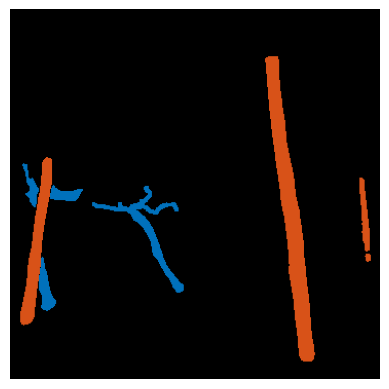

In [52]:
image_path = train_df.iloc[231]['masks']
image = Image.open(image_path)

# Преобразовать изображение в массив NumPy
image_np = np.array(image)
# Добавить дополнительное измерение для совместимости с формой, ожидаемой моделью
image_np = np.expand_dims(image_np, axis=0)

# Преобразовать в формат torch.Tensor и нормализовать
image = torch.Tensor(image_np)# / 255.0

print(image)
# Убедитесь, что image имеет правильную форму и тип данных
print(image.shape)  # Печатает (1, height, width)
print(image.dtype)  # Печатает torch.float32

plt.imshow(image_np[0], cmap='gray')  # Передаем нулевой индекс, так как у нас есть дополнительное измерение
plt.axis('off')  # Отключаем оси координат
plt.show()

In [49]:
colormap = {'__background__': [0, 0, 0], 'wine': [0, 113, 188], 'post': [216, 82, 24]}.values()
print(colormap)
# mask_path = train_df.iloc[231]['masks']
mask = Image.open('D:/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_8071_label_ground-truth_coco-panoptic.png')
mask = np.array(mask)
print(type(mask[0][0][0]))
output = np.zeros(mask.shape[:2])
for label, color in enumerate(colormap):
    print(label, color)
    if label < len(colormap):
        output[np.all(np.equal(mask, color), axis=-1)] = label
        
print(output)

dict_values([[0, 0, 0], [0, 113, 188], [216, 82, 24]])
<class 'numpy.uint8'>
0 [0, 0, 0]
1 [0, 113, 188]
2 [216, 82, 24]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
mask = torch.from_numpy(mask).type(torch.LongTensor)

In [54]:
train_data_custom[48][1].shape

torch.Size([3, 32, 32])

## class MultiClassDataset(Dataset):

Создадим свой класс для датасета. На этот раз для многоклассовой сегментации

In [101]:
# Creating the dataset class
class MultiClassDataset(Dataset):
    """
        dataset_dir: str - TRAIN_DATA, VAL_DATA, TEST_DATA 
    """
    def __init__(self,
                 dataset_dir: str, # TRAIN_DIR VAL_DIR TEST_DIR
                 annotation_dir: str,
                 #file_list: list,
                 #image_list=None,
                 #mask_list:=None,
                 transform=None):
        self.dataset_dir = dataset_dir  
        self.file_list = os.listdir(dataset_dir)
        self.image_list, self.mask_list = get_image_and_mask_lists(os.listdir(dataset_dir))
        #self.image_list = image_list
        #self.mask_list = mask_list        
        self.classes, self.class_to_idx, self.colors_to_idx = find_classes(annotation_dir)
        self.colormap = self.colors_to_idx.values()
        self.transform = transform

    def rgbmask_to_label(self,
                         rgb_mask: np.ndarray,
                         colormap: list):
        """
        Converts a single RGB masks into onehot encoding masks and finally
        creates a single channel class index label.
        Parameters:
            rgb_mask: A array containing the mask in RGB format and shape (HWC).
            colormap: A list with all the RGB colors for every single class
                      in proper sequence.
        Returns:
            output: A array that is converted from RGB mask to label encoded in
                    shape (H x W).
        """
        # A array to fill the output later.
        output = np.zeros(rgb_mask.shape[:2])

        for label, color in enumerate(colormap):
            if label < len(colormap):
                # Matching the mask with the colormap
                # Then replacing with classes index
                output[np.all(np.equal(rgb_mask, color), axis=-1)] = label

        return output


    
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        
        image_path = os.path.join(self.dataset_dir, self.image_list[index])
        mask_path = os.path.join(self.dataset_dir, self.mask_list[index])

        # Чтение файлов изображения и маски в формате RGB
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

        # Преобразование изображения и масок с использованием аугментации
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        # Преобразование маски в формат кодированных меток
        mask = (mask.detach().numpy() if type(mask) == torch.Tensor else mask)
        mask = self.rgbmask_to_label(rgb_mask=mask,
                                     colormap=self.colormap)
        mask = torch.from_numpy(mask).type(torch.LongTensor)
        return image, mask

In [103]:
dataset = MultiClassDataset(TRAIN_DIR, ANNOTATION_DATA_PATH)

## Display sample random images

Size of the dataset: 210
Shape of Image: (360, 360, 3) and mask: torch.Size([360, 360])
Classes in the mask images: [0 1]

Plotting the data:


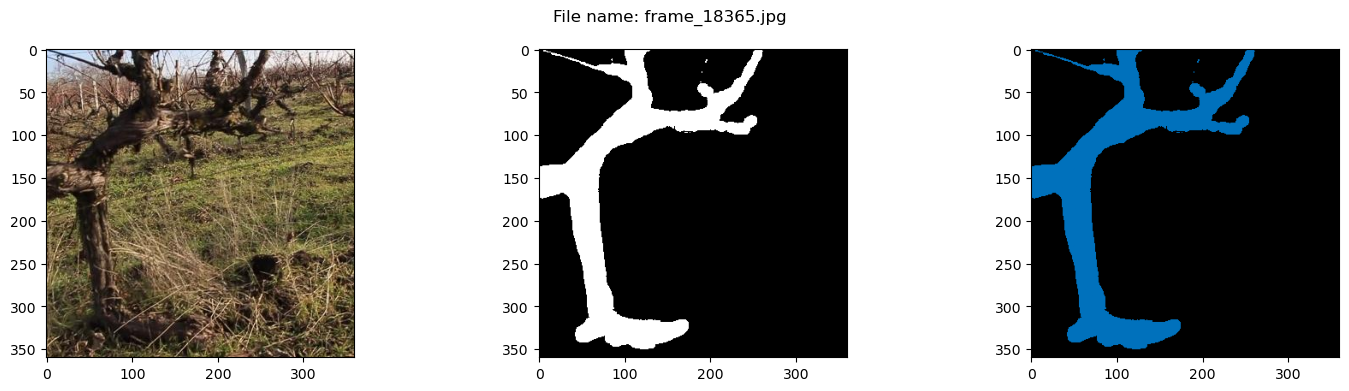

In [135]:
rand_num = np.random.randint(len(dataset))
image, mask = dataset[rand_num]

print(f'Size of the dataset: {len(dataset)}')
print(f'Shape of Image: {image.shape} and mask: {mask.shape}')
print(f'Classes in the mask images: {np.unique(mask)}')
print('\nPlotting the data:')

filename = dataset.image_list[rand_num]
maskname = dataset.mask_list[rand_num]
plt.figure(figsize=(18, 4))
plt.suptitle(f'File name: {filename}')
plt.subplot(131)
plt.imshow(image)
plt.subplot(132)
plt.imshow(mask, 'gray')
plt.subplot(133)
plt.imshow(plt.imread(os.path.join(dataset.dataset_dir, maskname)))

[ 18  20 130  76  79]


TypeError: Invalid shape (360, 3, 360) for image data

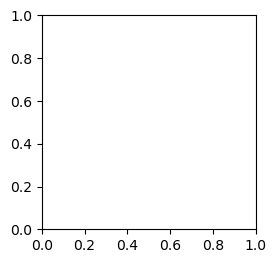

In [126]:
# Display random images from ImageFolder created Dataset
display_random_images(dataset,
                      n=5,
                      classes=dataset.classes,
                      seed=None)

# Load dataset into batches

In [127]:
trainloader = DataLoader(train_data_custom, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(test_data_custom, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

NameError: name 'train_data_custom' is not defined

In [ ]:
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([32, 3, 32, 32])
Size of one batch of masks: torch.Size([32, 1, 32, 32])


# Create Segmentation Model

There are many CNN model architectures present in the pytorch's segmentation models documentation that can be used but for this project I will use Unet++ architecture. [Unet++](https://arxiv.org/abs/1807.10165) is a fully convolutional neural network for image semantic segmentation. It consists of encoder and decoder parts connected with skip connections. The encoder extract features of different spatial resolution (skip connections) which are used by decoder to define accurate segmentation masks. It uses concatenation for fusing decoder blocks with skip connections.

**Documentation**: https://segmentation-models-pytorch.readthedocs.io/en/latest/models.html#id2

![UNet++ architecture](https://pic.imgdb.cn/item/60dac54e5132923bf81d4a25.jpg)

I will now create the Segmentation model using the Unet++ architecture. The parameters used for the model are:
- **Efficient Net** is used as the encoder model
- Weights used are of **Imagenet**
- Input channels are 3 due to **RGB** images

In the forward method I defined the loss functions. DiceLoss and Binary Cross Entropy are used as loss functions for this task.

[Dice loss](https://serp.ai/dice-loss/#:~:text=Dice%20Loss%20is%20an%20important,true%20segmentation%20of%20an%20image.) is a metric commonly used to evaluate the performance of machine learning models in image segmentation tasks. It is a measure of the dissimilarity between the predicted segmentation (mask) and the true segmentation of an image.

In [ ]:
target_mask = torch.randint(0, 3, (1, 256, 256))
target_mask.shape

torch.Size([1, 256, 256])

In [ ]:

gc.collect()

0

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=3,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks != None:
            loss1 = DiceLoss(mode='multiclass')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

# Create Train and Validation Function

In [ ]:
# Function to train the model
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

Before training the model make sure that your GPU is running because it would take eternity to train the model on a CPU.

In [ ]:
gc.collect()

23501

In [ ]:
torch.cuda.empty_cache()

### Свернуть

In [ ]:
input_image = torch.randn(1, 3, 32, 32)  # Пример входного изображения
target_mask = torch.randint(0, 2, (3, 32, 32))  # Пример метки классов

input_image = input_image.to(DEVICE)
target_mask = target_mask.to(DEVICE)

# Предсказываем маску сегментации
output_mask = model(input_image)

# Вычисляем потери
loss = loss_function(output_mask, target_mask)

# Выводим размерность выходной маски
print("Размерность выходной маски:", output_mask.shape)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 672, 1, 1])

# Model Training

In [ ]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training and evaluation loop
best_val_loss = 1e9

for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")

        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

In only 10 epochs the model reduced the validation loss to close to 0.2 which is very good. THis shows the power of the Unet architecture on Image segmentation preoblems. Now let's see how our model predictions look in comparison to the original masks.

# Inference

In [ ]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# Function to output the prediction mask
def make_inference(idx):
    image, mask = test_data_custom[idx]
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

    # Predicted mask
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0

    return image, mask, pred_mask

In [ ]:
# Compare predictions with original
for i in np.random.randint(0, len(test_data_custom), 5):
    image, mask, pred_mask = make_inference(i)

    # Show image
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title('IMAGE');

    # Show original mask
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH');

    # Show predicted mask
    plt.subplot(1,3,3)
    plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION');

The model performs fairly decent but there is still room for improvement. To further improve the performance the below mentioned steps can be

**Steps to improve the model performance:**
- Try running the model for more epochs
- Try using different model architectures
- Try using different encoder models
- Try using more efficient methods such as early stopping to prevent overfitting
- Try using differnt learning rate schedulers to reduce learning rate near convergence region.

**Consider giving an upvote👍 if you liked the notebook. It will help it to reach a wider audience.**

**It would be highly appreciated if you can take out some time to share your views on what you liked in the notebook and what can be the potential improvements that can be made to further improve the notebook.**

**Thanks**

# References

- **Notebook inspired from this project**: https://www.coursera.org/projects/deep-learning-with-pytorch-image-segmentation
- **Image Segmentation**: https://www.ibm.com/topics/image-segmentation
- **albumentations documentation**: https://albumentations.ai/docs/
- **segmentation_models_pytorch documentation**: https://smp.readthedocs.io/en/latest/
- **Unet++ original paper**: https://arxiv.org/abs/1807.10165
- **Dice Loss**: https://serp.ai/dice-loss/#:~:text=Dice%20Loss%20is%20an%20important,true%20segmentation%20of%20an%20image.

In [ ]:
torch.cuda.empty_cache()